In [359]:
import random
import pandas as pd
import yaml
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from modeling import ThreeLayerClassifier
players = pd.read_csv('C:/Github/nfl_sim/data/depth.csv',
                      usecols=['season', 'club_code', 'week',  'dense_depth','formation', 'gsis_id',
       'position', 'full_name'])
rb_stats =  pd.read_csv('data/rb_stats.csv',index_col=0)

In [360]:
model_path = "models/run_yards_gained.pt"
model = ThreeLayerClassifier()
model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [361]:
player_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')

players = player_stats[['player_id','week','season', 'ppr_roll','rush_roll']].merge(players,left_on=['player_id','week','season'],right_on=['gsis_id','week','season'])

In [362]:
player_stats.loc[(player_stats.player_id=='00-0034844') & (player_stats.season==2024)]
# will ship '00-0039746'

,player_id,player_display_name,position,position_group,week,season_type,season,opponent_team,recent_team,ppr_roll,rush_roll
60,00-0034844,Saquon Barkley,RB,RB,1.0,REG,2024,GB,PHI,22.200001,86.289100
13981,00-0034844,Saquon Barkley,RB,RB,2.0,REG,2024,ATL,PHI,18.969251,74.199966
29574,00-0034844,Saquon Barkley,RB,RB,3.0,REG,2024,NO,PHI,24.661667,100.017067
38198,00-0034844,Saquon Barkley,RB,RB,4.0,REG,2024,TB,PHI,12.995952,47.478722
58865,00-0034844,Saquon Barkley,RB,RB,5.0,None,2024,None,None,9.253478,33.575881
71074,00-0034844,Saquon Barkley,RB,RB,6.0,REG,2024,CLE,PHI,10.528427,39.305707
82293,00-0034844,Saquon Barkley,RB,RB,7.0,REG,2024,NYG,PHI,18.541777,98.815110
92198,00-0034844,Saquon Barkley,RB,RB,8.0,REG,2024,CIN,PHI,16.339246,73.588821
111644,00-0034844,Saquon Barkley,RB,RB,9.0,REG,2024,JAX,PHI,21.326444,113.767058
114951,00-0034844,Saquon Barkley,RB,RB,10.0,REG,2024,DAL,PHI,9.208197,62.574543


In [363]:
player_stats.loc[(player_stats.player_id=='00-0036919') & (player_stats.season==2024)]
# will ship '00-0039746'

,player_id,player_display_name,position,position_group,week,season_type,season,opponent_team,recent_team,ppr_roll,rush_roll
4067,00-0036919,Kenneth Gainwell,RB,RB,1.0,REG,2024,GB,PHI,2.200000,2.000000
24293,00-0036919,Kenneth Gainwell,RB,RB,2.0,REG,2024,ATL,PHI,6.624644,23.895735
31961,00-0036919,Kenneth Gainwell,RB,RB,3.0,REG,2024,NO,PHI,4.129445,12.575142
38004,00-0036919,Kenneth Gainwell,RB,RB,4.0,REG,2024,TB,PHI,3.047403,11.377273
58644,00-0036919,Kenneth Gainwell,RB,RB,5.0,None,2024,None,None,3.571839,12.000320
71316,00-0036919,Kenneth Gainwell,RB,RB,6.0,REG,2024,CLE,PHI,2.457334,16.876896
81598,00-0036919,Kenneth Gainwell,RB,RB,7.0,REG,2024,NYG,PHI,4.204959,29.918447
94217,00-0036919,Kenneth Gainwell,RB,RB,8.0,REG,2024,CIN,PHI,3.572625,12.837894
104600,00-0036919,Kenneth Gainwell,RB,RB,9.0,REG,2024,JAX,PHI,5.957557,13.980325
113921,00-0036919,Kenneth Gainwell,RB,RB,10.0,REG,2024,DAL,PHI,5.605038,19.320219


In [364]:
class QB:
    def __init__(self, d):  # noqa: F811
        self.name = d["full_name"]
        self.attempts = 0
        self.completions = 0
        self.rush_yards = 0
        self.pass_yards = 0
        self.td = 0
        self.int = 0

    def __repr__(self):
        return f"QB:{self.name} has {self.completions} completions for {self.pass_yards} yards"


class RB:
    def __init__(self, d):
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.depth_team= int(d['dense_depth'])
        self.rush_yards = 0
        self.receiving_yards = 0
        self.targets = 0
        self.receptions = 0
        self.td = 0
        self.carries = 0
        self.features= d.to_dict()

    def __repr__(self):
        return f"RB:{self.name} has {self.carries} carries for {self.rush_yards} yards"


class WR:
    def __init__(self, d):
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.rush_yards = 0
        self.receiving_yards = 0
        self.targets = 0
        self.receptions = 0
        self.td = 0
        self.carries = 0

    def __repr__(self):
        return f"WR:{self.name} has {self.receptions} receptions for {self.receiving_yards} yards"


class Team:
    def __init__(self, name, season, week, use_current_injuries=False):
        self.name = name
        self.score = 0
        self.plays = 0
        self.players = players.loc[
            (players.club_code == name) & (players.season == season)
        ]
        self.players = self.players.loc[
            (self.players.week == min(self.players.week.max(), week))
            & (self.players.formation == "Offense")
            & (self.players.position.isin(["QB", "WR", "TE", "RB"]))
        ].sort_values(by='dense_depth')

        self.QBs = self.get_players_by_position("QB")
        self.RBs = self.get_players_by_position("RB")
        self.WRs = self.get_players_by_position("WR")
        self.rb_stats = rb_stats.loc[
            (rb_stats.team_name == name) & (rb_stats.season == season)
        ]
        self.rb_stats = self.rb_stats.loc[
            (self.rb_stats.week == min(self.rb_stats.week.max(), week))
        ].to_dict(orient='records')[0]

    def get_players_by_position(self, position):
        """Filter players by position and create player objects."""
        position_data = self.players[(self.players["position"] == position)]

        # Create player objects based on position
        players = []
        for _, player_data in position_data.iterrows():
            if position == "WR":
                players.append(WR(player_data))
            elif position == "RB":
                players.append(RB(player_data))
            elif position == "QB":
                players.append(QB(player_data))
        return players

In [365]:
vik = Team('PHI',2024, 12)
vik.RBs

[RB:Saquon Barkley has 0 carries for 0 yards,
 RB:Kenneth Gainwell has 0 carries for 0 yards,
 RB:Will Shipley has 0 carries for 0 yards]

In [366]:
vik = Team('PHI',2024, 13)
det = Team('DET',2024, 13)
vik.players

,player_id,week,season,ppr_roll,rush_roll,club_code,formation,gsis_id,position,full_name,dense_depth
95375,00-0034351,12.0,2024,5.813759,0.000000,PHI,Offense,00-0034351,TE,Dallas Goedert,0.0
96306,00-0035676,12.0,2024,10.415805,0.017981,PHI,Offense,00-0035676,WR,A.J. Brown,0.0
97975,00-0036389,12.0,2024,7.360464,38.947534,PHI,Offense,00-0036389,QB,Jalen Hurts,0.0
98810,00-0034844,12.0,2024,16.618900,59.878482,PHI,Offense,00-0034844,RB,Saquon Barkley,0.0
96805,00-0036919,12.0,2024,2.171406,3.734997,PHI,Offense,00-0036919,RB,Kenneth Gainwell,1.0
96880,00-0036912,12.0,2024,7.490311,0.000000,PHI,Offense,00-0036912,WR,DeVonta Smith,1.0
96908,00-0038102,12.0,2024,4.320332,6.468106,PHI,Offense,00-0038102,QB,Kenny Pickett,1.0
97392,00-0037086,12.0,2024,0.190187,0.000000,PHI,Offense,00-0037086,TE,Grant Calcaterra,1.0
96352,00-0037741,12.0,2024,2.502428,0.448831,PHI,Offense,00-0037741,WR,Jahan Dotson,2.0
99253,00-0039746,12.0,2024,0.554065,5.540646,PHI,Offense,00-0039746,RB,Will Shipley,2.0


In [367]:
vik.rb_stats

{'team_name': 'PHI',
 'season': 2024,
 'week': 12.0,
 'game_type': 'REG',
 'gsis_id_RB_1': '00-0036919',
 'gsis_id_RB_2': '00-0039746',
 'gsis_id_RB_0': '00-0034844',
 'full_name_RB_1': 'Kenneth Gainwell',
 'full_name_RB_2': 'Will Shipley',
 'full_name_RB_0': 'Saquon Barkley',
 'ppr_roll_RB_1': 2.171405688261838,
 'ppr_roll_RB_2': 0.554064620108907,
 'ppr_roll_RB_0': 16.618899520930523,
 'rush_roll_RB_1': 3.734997177124365,
 'rush_roll_RB_2': 5.540646066616731,
 'rush_roll_RB_0': 59.87848224947137,
 'carries_roll_RB_1': 0.7103958522104779,
 'carries_roll_RB_2': 1.830293261527084,
 'carries_roll_RB_0': 10.11835784258171}

In [368]:
det.RBs

[RB:David Montgomery has 0 carries for 0 yards,
 RB:Jahmyr Gibbs has 0 carries for 0 yards,
 RB:Craig Reynolds has 0 carries for 0 yards,
 RB:Sione Vaki has 0 carries for 0 yards]

In [369]:
class GameState:


	def __init__(self, home, away, config):
		self.home =home
		self.away = away
		self.quarter = 1
		self.possession = None
		self.down = 1
		self.togo = 10
		self.ball_position = 35  # Yardline (0-100, 50 is midfield)
		self.clock = 900  # Seconds in the current quarter (15 mins = 900 seconds)
		self.home_timeouts = 3
		self.away_timeouts = 3
		self.pbp = []
		self.run_or_pass = joblib.load('models/run_or_pass.joblib')
		self.run_or_pass_cols = config['run_or_pass_cols']
		self.choose_rusher = joblib.load('models/choose_rusher.joblib')
		self.choose_rusher_cols = config['choose_rusher_cols']
		self.play_encoding = config['play_encoding']
		self.wind = random.randint(0,10)
		self.temp = random.randint(40,90)
		self.play_functions = {
			'field_goal': self.field_goal,
			'no_play': self.run_play,
			'pass': self.pass_play,
			'punt': self.punt,
			'qb_kneel': self.qb_kneel,
			'qb_spike': self.qb_spike,
			'run': self.run_play
			}
		
		
	def switch_poss(self):
		self.possession = self.away if self.possession == self.home else self.home 
		self.ball_position = 100 - min(self.ball_position, 100)
		self.down = 1
		self.togo = min(10, (100-self.ball_position))
		return
	
	def kickoff(self):
		self.switch_poss()
		self.ball_position = 35
		pass
	
	def start_game(self):
		lost_kickoff = random.choice((self.home, self.away))
		self.possession=lost_kickoff
		self.kickoff()
		print(f'{self.possession.name} has won the kickoff')
		self.log_play()
		self.log_play_type('kickoff',0)

	def play(self, team):
		self.log_play()
		team.plays += 1
		features = [self.pbp[-1][key] for key in self.run_or_pass_cols]
		preds = self.run_or_pass.predict_proba([features])
		play_type_int = np.random.choice(len(preds[0]), p=preds[0])
		play_type = self.play_encoding.get(play_type_int, 1)
		yds = self.play_functions[play_type](team)
		self.togo -= yds
		self.ball_position += yds
		self.clock -= random.randint(10, 40)
		self.td_check(team)
		self.check_downs(team)
		self.log_play_type(play_type, yds)


	def log_play(self):
		"""Logs the context of the game state at each play."""
		play_data = {
			"possession": self.possession.name,
			"quarter": self.quarter,
			"down": self.down,
			"ydstogo": self.togo,
			"goal_to_go": int(self.ball_position >= 100-self.togo),
			"yardline_100": self.ball_position,
			"total_home_score": self.home.score,
			"total_away_score": self.away.score,
			"posteam_score": self.possession.score,
			"score_differential": (self.home.score - self.away.score),
			"wind": self.wind,
			"temp": self.temp,
			"quarter_seconds_remaining": self.clock,
			'half_seconds_remaining': self.clock + (900 * (self.quarter%2)),
    		'game_seconds_remaining': self.clock + (900 * (4-self.quarter)),
			'spread_line':-2.5,
			'total_line': 42.5
		}

		self.pbp.append(play_data)

	def log_play_type(self,play_type, yds,verbose=False):
		self.pbp[-1]['play_type'] = play_type
		self.pbp[-1]['yards_gained'] = yds
		if verbose:
			print(
				f'{self.possession.name} {play_type} for {yds} yards, {self.pbp[-1]['yardline_100']} yd line,' + 
				f' {self.pbp[-1]['ydstogo']} yds to go on {self.pbp[-1]['down']} down.' + 
				f' {self.pbp[-1]['quarter_seconds_remaining'] // 60}:{self.pbp[-1]['quarter_seconds_remaining']  % 60} left'
			)
		return
	
	def sample_run_yards(self, model, player):
		rush_yards_cols = ['yardline_100','down','ppr_roll']
		raw_features = dict(self.pbp[-1])
		raw_features.update(player.features)
		x = [raw_features[key] for key in rush_yards_cols]
		x = torch.tensor(x)
		with torch.no_grad():
			preds = model(x.reshape(1,-1))[0]
			preds = torch.softmax(preds,0)
		sample = (torch.multinomial(preds,1) - 20).item()
		return min((sample, raw_features['yardline_100']))


	def run_play(self, team):
		raw_features = dict(self.pbp[-1])
		raw_features.update(team.rb_stats)
		features = [raw_features[key] for key in self.choose_rusher_cols]
		preds = self.choose_rusher.predict_proba([features])
		rusher_depth = np.random.choice(len(preds[0]), p=preds[0])
		print('i choose u pikachu',rusher_depth,[round(100 * x) for x in preds[0]])
		for x in team.RBs:
			if x.depth_team == rusher_depth:
				player = x
				break
		player.carries += 1
		yds = self.sample_run_yards(model, player)
		player.rush_yards += yds
		return yds

	def pass_play(self, team):
		passer = team.QBs[0]
		receiver = random.choice(team.WRs)
		passer.attempts += 1
		receiver.targets += 1
		if random.randint(0, 100) > 50:
			passer.completions += 1
			receiver.receptions += 1
			yds = random.randint(-1, 30)
			receiver.receiving_yards += yds
			passer.pass_yards += yds
		else:
			yds = 0
		return yds
	
	
	def punt(self, team):
		self.switch_poss()
		self.ball_position -= random.randint(30, 60)
		if self.ball_position < 0:
			self.ball_position = 25
		return 0
	
	def field_goal(self,team):
		result = random.randint(0,100)
		if result > 50:
			team.score += 3
			self.switch_poss()
			self.ball_position = 35
			print(f'{team.name} scored a FG')
		else:
			print(f'{team.name} missed FG')
			self.switch_poss()
		return 0
	
	def qb_kneel(self, team):
		# Implementation of qb kneel play
		print("QB kneel executed.")
		return -1

	def qb_spike(self, team):
		# Implementation of qb spike play
		print("QB spike executed.")
		return 0
	
	def td_check(self, team):
		if self.ball_position > 100:
			team.score += 7
			self.kickoff()
			print(f'{team.name} scored a TD')
		return
	
	def check_downs(self, team):
		if self.togo <= 0:
			self.togo = 10
			self.down = 1
		elif self.down == 4:
			self.switch_poss()
		else:
			self.down += 1


	def play_quarter(self):
		self.clock = 900
		while self.clock > 0:
			self.play(self.possession)
		self.quarter += 1
		print(f'{self.home.name}:{self.home.score}')
		print(f'{self.away.name}:{self.away.score}')

	def play_game(self):
		while self.quarter <= 4:
			self.play_quarter()
			print(self.quarter)


In [370]:
with open('models/feature_config.yaml', 'r') as file:
    config = yaml.safe_load(file)
game = GameState(vik, det, config)
game.start_game()
game.play_game()


PHI has won the kickoff
i choose u pikachu 0 [97, 1, 2]
i choose u pikachu 0 [99, 0, 1]
i choose u pikachu 0 [98, 1, 1]
PHI scored a TD
i choose u pikachu 0 [38, 62, 0]
i choose u pikachu 0 [51, 49, 0]
i choose u pikachu 1 [42, 58, 0]
i choose u pikachu 0 [53, 47, 0]
i choose u pikachu 1 [59, 41, 0]
DET scored a TD
DET scored a FG
i choose u pikachu 0 [92, 0, 7]
PHI:7
DET:10
2
i choose u pikachu 1 [53, 47, 0]
i choose u pikachu 1 [53, 47, 0]
i choose u pikachu 0 [54, 46, 0]
i choose u pikachu 0 [62, 38, 0]
DET scored a TD
PHI missed FG
i choose u pikachu 0 [61, 39, 0]
i choose u pikachu 0 [76, 2, 22]
i choose u pikachu 0 [74, 2, 24]
i choose u pikachu 1 [66, 10, 25]
PHI missed FG
i choose u pikachu 0 [68, 32, 0]
i choose u pikachu 1 [79, 2, 19]
i choose u pikachu 0 [48, 1, 51]
PHI scored a TD
PHI:14
DET:17
3
i choose u pikachu 0 [90, 0, 9]
i choose u pikachu 2 [90, 1, 9]
i choose u pikachu 1 [87, 2, 11]
i choose u pikachu 2 [88, 2, 10]
i choose u pikachu 2 [84, 1, 15]
i choose u pikach

In [371]:
print(game.away.plays, game.home.plays)

72 76


In [372]:
pbp = pd.json_normalize(game.pbp)
pbp

,possession,quarter,down,ydstogo,goal_to_go,yardline_100,total_home_score,total_away_score,posteam_score,score_differential,wind,temp,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,spread_line,total_line,play_type,yards_gained
0,PHI,1,1,10,0,35,0,0,0,0,0,58,900,1800,3600,-2.5,42.5,kickoff,0
1,PHI,1,1,10,0,35,0,0,0,0,0,58,900,1800,3600,-2.5,42.5,run,34
2,PHI,1,1,10,0,69,0,0,0,0,0,58,879,1779,3579,-2.5,42.5,run,6
3,PHI,1,2,4,0,75,0,0,0,0,0,58,858,1758,3558,-2.5,42.5,run,4
4,PHI,1,1,10,0,79,0,0,0,0,0,58,822,1722,3522,-2.5,42.5,pass,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PHI,4,1,10,1,91,31,31,31,0,0,58,106,106,106,-2.5,42.5,run,0
145,PHI,4,2,10,1,91,31,31,31,0,0,58,79,79,79,-2.5,42.5,pass,19
146,DET,4,2,10,0,35,38,31,31,7,0,58,57,57,57,-2.5,42.5,no_play,6
147,DET,4,3,4,0,41,38,31,31,7,0,58,38,38,38,-2.5,42.5,qb_kneel,-1


In [373]:
features = [game.pbp[-5][key] for key in game.run_or_pass_cols]
preds = game.run_or_pass.predict_proba([features])
features

[91, 1, 1, 10, 31, 0, 106, 106, 106, 0, 58, -2.5, 42.5]

In [374]:
vik.RBs

[RB:Saquon Barkley has 20 carries for 136 yards,
 RB:Kenneth Gainwell has 3 carries for -1 yards,
 RB:Will Shipley has 3 carries for 8 yards]

In [375]:
vik.RBs[1].features

{'player_id': '00-0036919',
 'week': 12.0,
 'season': 2024,
 'ppr_roll': 2.171405688261838,
 'rush_roll': 3.734997177124365,
 'club_code': 'PHI',
 'formation': 'Offense',
 'gsis_id': '00-0036919',
 'position': 'RB',
 'full_name': 'Kenneth Gainwell',
 'dense_depth': 1.0}

In [376]:
139/24

5.791666666666667

In [377]:
det.RBs

[RB:David Montgomery has 11 carries for 62 yards,
 RB:Jahmyr Gibbs has 12 carries for 79 yards,
 RB:Craig Reynolds has 0 carries for 0 yards,
 RB:Sione Vaki has 0 carries for 0 yards]

In [378]:
pbp.head(15)

,possession,quarter,down,ydstogo,goal_to_go,yardline_100,total_home_score,total_away_score,posteam_score,score_differential,wind,temp,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,spread_line,total_line,play_type,yards_gained
0,PHI,1,1,10,0,35,0,0,0,0,0,58,900,1800,3600,-2.5,42.5,kickoff,0
1,PHI,1,1,10,0,35,0,0,0,0,0,58,900,1800,3600,-2.5,42.5,run,34
2,PHI,1,1,10,0,69,0,0,0,0,0,58,879,1779,3579,-2.5,42.5,run,6
3,PHI,1,2,4,0,75,0,0,0,0,0,58,858,1758,3558,-2.5,42.5,run,4
4,PHI,1,1,10,0,79,0,0,0,0,0,58,822,1722,3522,-2.5,42.5,pass,0
5,PHI,1,2,10,0,79,0,0,0,0,0,58,790,1690,3490,-2.5,42.5,pass,27
6,DET,1,2,10,0,35,7,0,0,7,0,58,777,1677,3477,-2.5,42.5,pass,28
7,DET,1,1,10,0,63,7,0,0,7,0,58,765,1665,3465,-2.5,42.5,pass,0
8,DET,1,2,10,0,63,7,0,0,7,0,58,744,1644,3444,-2.5,42.5,run,9
9,DET,1,3,1,0,72,7,0,0,7,0,58,727,1627,3427,-2.5,42.5,run,3


In [379]:
pbp.loc[(pbp.play_type=='run') & (pbp.possession=='PHI')]

,possession,quarter,down,ydstogo,goal_to_go,yardline_100,total_home_score,total_away_score,posteam_score,score_differential,wind,temp,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,spread_line,total_line,play_type,yards_gained
1,PHI,1,1,10,0,35,0,0,0,0,0,58,900,1800,3600,-2.5,42.5,run,34
2,PHI,1,1,10,0,69,0,0,0,0,0,58,879,1779,3579,-2.5,42.5,run,6
3,PHI,1,2,4,0,75,0,0,0,0,0,58,858,1758,3558,-2.5,42.5,run,4
35,PHI,1,1,10,0,63,7,10,7,-3,0,58,8,908,2708,-2.5,42.5,run,3
56,PHI,2,2,10,0,25,7,17,7,-10,0,58,401,401,2201,-2.5,42.5,run,15
58,PHI,2,2,12,0,38,7,17,7,-10,0,58,356,356,2156,-2.5,42.5,run,-2
64,PHI,2,1,10,0,32,7,17,7,-10,0,58,197,197,1997,-2.5,42.5,run,1
75,PHI,3,1,10,0,58,14,17,14,-3,0,58,835,1735,1735,-2.5,42.5,run,5
76,PHI,3,2,5,0,63,14,17,14,-3,0,58,820,1720,1720,-2.5,42.5,run,4
77,PHI,3,3,1,0,67,14,17,14,-3,0,58,810,1710,1710,-2.5,42.5,run,0


In [380]:
game.home.RBs[0].features

{'player_id': '00-0034844',
 'week': 12.0,
 'season': 2024,
 'ppr_roll': 16.618899520930523,
 'rush_roll': 59.87848224947137,
 'club_code': 'PHI',
 'formation': 'Offense',
 'gsis_id': '00-0034844',
 'position': 'RB',
 'full_name': 'Saquon Barkley',
 'dense_depth': 0.0}

In [381]:
raw_features = dict(game.pbp[-1])
raw_features.update(game.home.RBs[0].features)
rush_yards_cols = ['yardline_100','down','ppr_roll']


In [382]:
x = [raw_features[key] for key in rush_yards_cols]

In [383]:
x = torch.tensor(x)
x

tensor([40.0000,  4.0000, 16.6189])

In [384]:
def sample_run_yards(self, model, player):
    rush_yards_cols = ['yardline_100','down','ppr_roll']
    raw_features = dict(self.pbp[-1])
    raw_features.update(player.features)
    x = [raw_features[key] for key in rush_yards_cols]
    x = torch.tensor(x)
    with torch.no_grad():
        preds = model(x.reshape(1,-1))[0]
        preds = torch.softmax(preds,0)
    sample = torch.multinomial(preds,1) - 20
    return min((sample, raw_features['yardline_100']))

sample_run_yards(game, model, vik.RBs[0])

tensor([6])

In [385]:
with torch.no_grad():
    preds = model(x.reshape(1,-1))[0]
    #preds = torch.sigmoid(preds)

In [386]:
sig_preds= torch.sigmoid(preds)
soft_preds = torch.softmax(preds,0)

(array([0.00818182, 0.00545455, 0.01272727, 0.03090909, 0.04818182,
        0.05181818, 0.04818182, 0.03181818, 0.03636364, 0.63545455]),
 array([-8. , -6.9, -5.8, -4.7, -3.6, -2.5, -1.4, -0.3,  0.8,  1.9,  3. ]),
 <BarContainer object of 10 artists>)

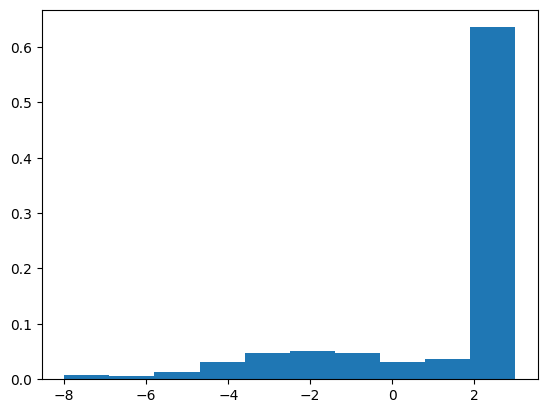

In [387]:
samples = torch.multinomial(sig_preds,1000,replacement=True) - 20
samples = torch.clamp(samples, max=3)
import matplotlib.pyplot as plt
plt.hist(samples,density=True)

(array([0.001, 0.   , 0.   , 0.008, 0.012, 0.026, 0.04 , 0.143, 0.112,
        0.658]),
 array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 <BarContainer object of 10 artists>)

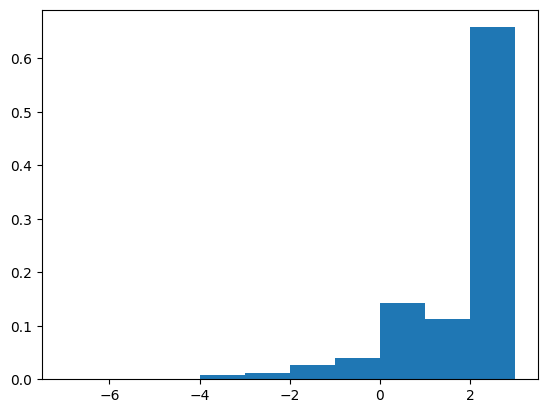

In [388]:
samples = torch.multinomial(soft_preds,1000,replacement=True) - 20
samples = torch.clamp(samples, max=3)
import matplotlib.pyplot as plt
plt.hist(samples,density=True)